In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import json
import time
import datetime
from poloniex import Poloniex

## Create working directory

In [62]:
from model import rnnModel as rnn
from model import portfolio_data as pf
from model import model_manager as mu
import logging

In [63]:
resultsDirectory = 'results/{}'.format(str(time.time()))
logger = pf.setupLogger(resultsDirectory)

## Get all coins

Download historical data from Poloniex exchange

In [33]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
%autoreload

In [34]:
from market import coinmarket

In [13]:
df_market_cap = coinmarket.get_all_coins()

In [14]:
df_market_cap.head()

,Ticker,MarketCap
0,BTC,1.272319e+11
1,ETH,5.945670e+10
2,XRP,2.423151e+10
3,BCH,1.766130e+10
4,EOS,1.076700e+10


In [15]:
coins = df_market_cap['Ticker'].unique()

In [17]:
polo = Poloniex()
start_time = 1388534400     # 2014.01.01
end_time = time.time()
usdt_coins_historical_data = {}
btc_coins_historical_data = {}

coins_without_data = []

for coin in coins:
    try:
        usdt_coins_historical_data[coin] = polo.returnChartData("USDT_{}".format(coin),86400, start_time, end_time)
    except Exception:
        try:
            btc_coins_historical_data[coin] = polo.returnChartData("BTC_{}".format(coin),86400, start_time, end_time)
        except Exception:
            coins_without_data.append(coin)

In [37]:
from market import operations

In [26]:
df_usdt_coins_historical_data = operations.transform_btc_to_usdt(btc_coins_historical_data,usdt_coins_historical_data, df_usdt_coins_historical_data['BTC'])

In [21]:
df_usdt_coins_historical_data['XMR'].head()

,close,high,low,open,volume,weightedAverage
date,,,,,,
2015-02-17 08:00:00,0.099,0.099,0.0100,0.0100,1.000000,0.081546
2015-02-18 08:00:00,0.099,0.099,0.0990,0.0990,0.000000,0.099000
2015-02-19 08:00:00,0.260,0.350,0.0886,0.0886,41.335836,0.241357
2015-02-20 08:00:00,0.250,0.260,0.2500,0.2600,28.846214,0.259936
2015-02-21 08:00:00,0.250,0.250,0.2500,0.2500,0.000000,0.250000


### Get top 8 traded coins

Set the time window that will be used to compute expected return and asset correlations

In [28]:
TRAIN_WINDOW = 730
VALID_WINDOW = 30
TEST_WINDOW = 90

In [42]:
coins_8_list = operations.get_k_top_traded_coins(TRAIN_WINDOW+TEST_WINDOW, df_usdt_coins_historical_data, 8)
print coins_8_list

[u'BTC' u'ETH' u'XRP' u'LTC' u'XMR' u'DASH' u'XEM' u'BCN']


Save to csv

In [19]:
for coin in coins_8_list:
    data_path = "./data/{}.csv".format(coin)
    df_usdt_coins_historical_data[coin].to_csv(data_path)

Split to train and test

In [46]:
df_usdt_coins_train_data = {}
df_usdt_coins_test_data = {}

for coin in coins_8_list:
    df_usdt_coins_train_data[coin] = df_usdt_coins_historical_data[coin][-(TRAIN_WINDOW+TEST_WINDOW):-TEST_WINDOW]
    df_usdt_coins_test_data[coin] = df_usdt_coins_historical_data[coin][-TEST_WINDOW:]

In [57]:
%autoreload

In [58]:
from market.portfolio_data import returns_data_frame, pf_correlation

In [156]:
df_returns_train = returns_data_frame(df_usdt_coins_train_data, "log")

,DASH,BCN,XEM,LTC,BTC,ETH,XRP,XMR
DASH,1.000000,0.140152,0.261742,0.320101,0.390931,0.377929,0.081352,0.422744
BCN,0.140152,1.000000,0.115944,0.138605,0.222704,0.136195,0.097753,0.124059
XEM,0.261742,0.115944,1.000000,0.287630,0.284881,0.252396,0.186436,0.209630
LTC,0.320101,0.138605,0.287630,1.000000,0.481944,0.313329,0.255940,0.310008
BTC,0.390931,0.222704,0.284881,0.481944,1.000000,0.350540,0.167810,0.382906
ETH,0.377929,0.136195,0.252396,0.313329,0.350540,1.000000,0.149677,0.342588
XRP,0.081352,0.097753,0.186436,0.255940,0.167810,0.149677,1.000000,0.155915
XMR,0.422744,0.124059,0.209630,0.310008,0.382906,0.342588,0.155915,1.000000


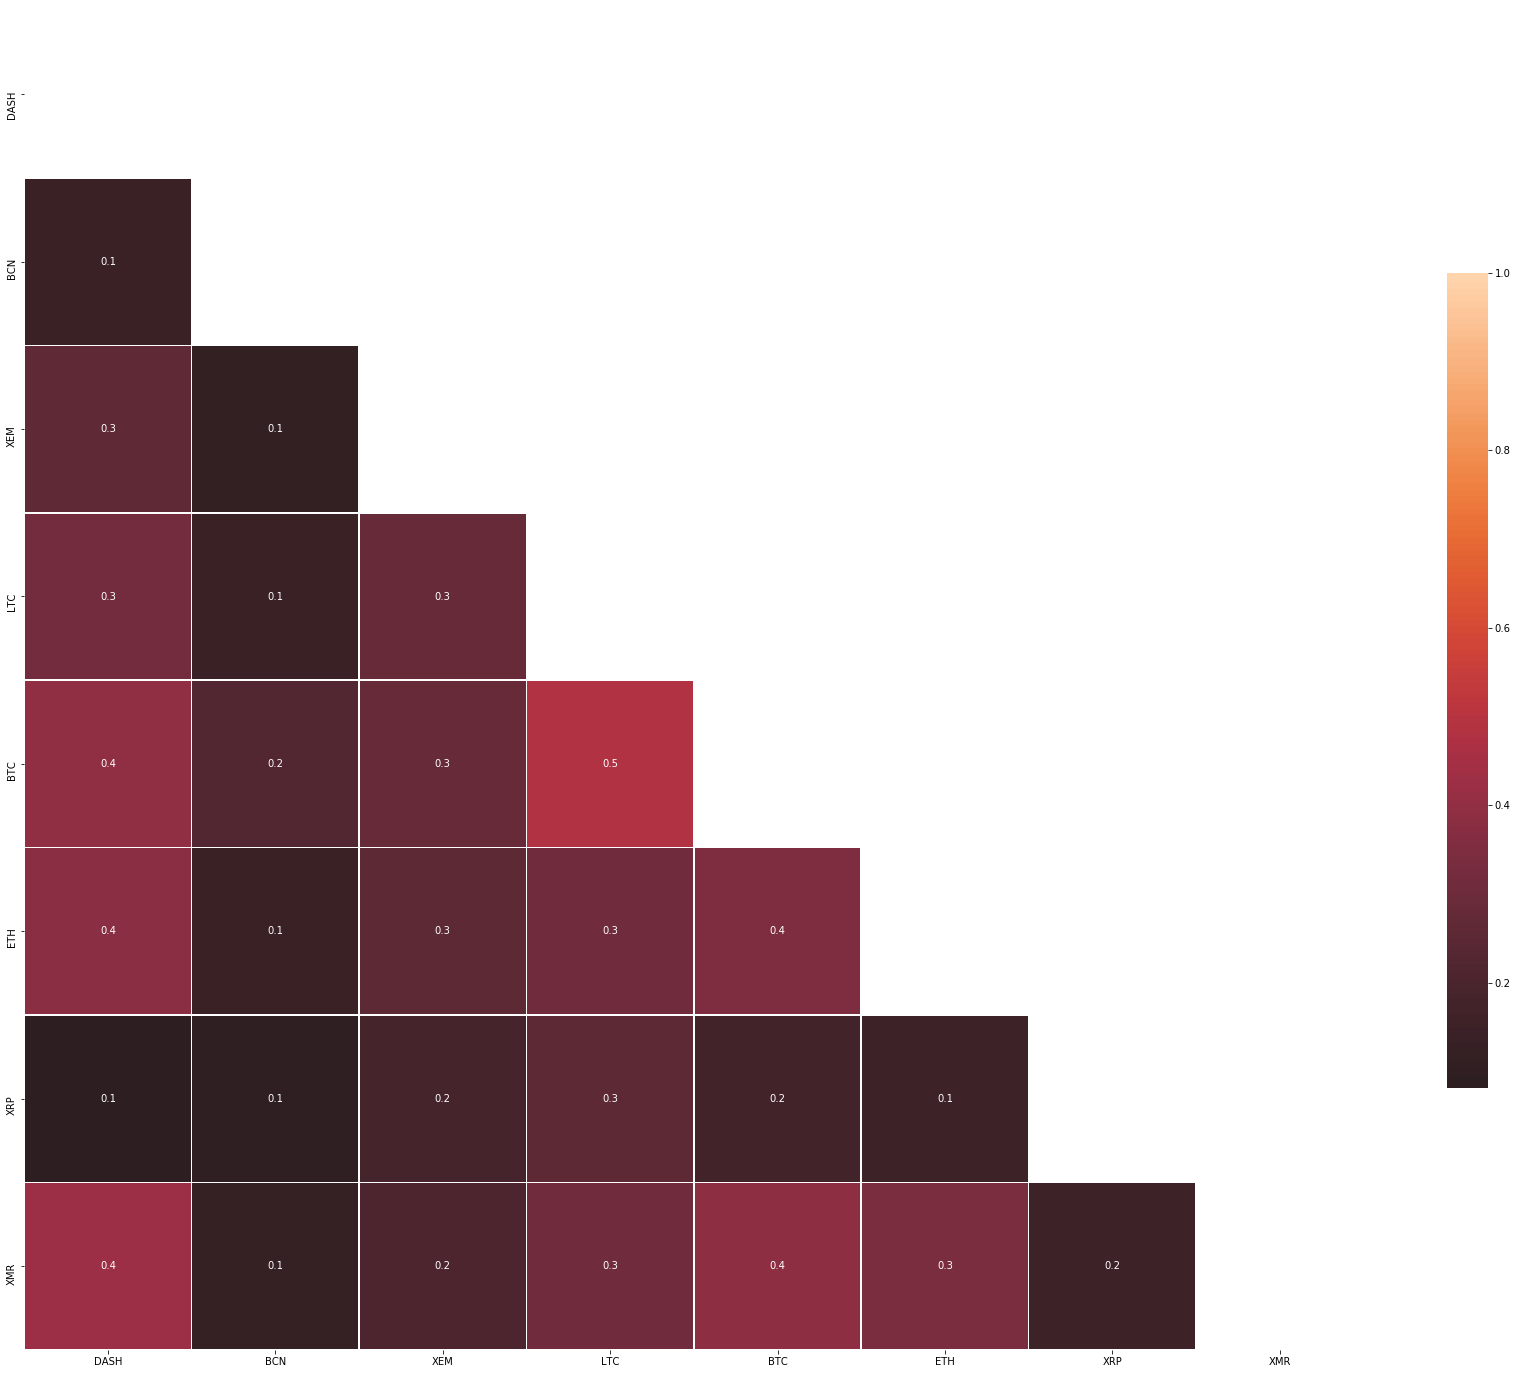

In [59]:
pf_correlation(df_usdt_coins_train_data, "log", (30,30))

## RNN model

In [64]:
M = len(coins_8_list)
W = TRAIN_WINDOW + TEST_WINDOW
L = len(df_usdt_coins_historical_data["BTC"].drop(["weightedAverage"], axis = 1).columns)
c = 0.0001
epochs = 100
transCostParams = {
    'c': np.array([ [c] for _ in range(M) ]),
    'c0': c
}

N = 15
Hs = 5
tol = 1e-7
Hs_arr = [5, 7, 10, 12, 15]
Ns_arr = [5, 7, 10, 12, 15]

print M,W,L

8 820 5


In [65]:
inputs = np.array([df_usdt_coins_historical_data[key][-W:].drop(["weightedAverage"], axis = 1).values for key in coins_8_list])
print inputs.shape
inputs = np.swapaxes(inputs,0,1)
print inputs.shape

(8, 820, 5)
(820, 8, 5)


In [66]:
returnTensor, prevReturnMatrix, nextReturnMatrix = pf.getInputs(inputs, N)

In [67]:
returnTensor.shape

(805, 8, 15, 5)

In [68]:
prevReturnMatrix.shape

(804, 8, 1)

In [69]:
nextReturnMatrix.shape

(804, 8, 1)

In [34]:
def Train(Hs,N,logger):
    returnTensor, prevReturnMatrix, nextReturnMatrix = pf.getInputs(inputs, N)
    
    TrainIndex = range(0,TRAIN_WINDOW)
    ValidationIndex = range(TRAIN_WINDOW,TRAIN_WINDOW+VALID_WINDOW)
    TestIndex = range(TRAIN_WINDOW,W-N-1)

    ## get training data
    returnTensor_Train = np.array([returnTensor[_] for _ in TrainIndex])
    prevReturnMatrix_Train = np.array([prevReturnMatrix[_] for _ in TrainIndex])
    nextReturnMatrix_Train = np.array([nextReturnMatrix[_] for _ in TrainIndex])

    ## get validation data
    returnTensor_Valid = np.array([returnTensor[_] for _ in ValidationIndex])
    prevReturnMatrix_Valid = np.array([prevReturnMatrix[_] for _ in ValidationIndex])
    nextReturnMatrix_Valid = np.array([nextReturnMatrix[_] for _ in ValidationIndex])

    ## get testing data
    returnTensor_Test = np.array([returnTensor[_] for _ in TestIndex])
    prevReturnMatrix_Test = np.array([prevReturnMatrix[_] for _ in TestIndex])
    nextReturnMatrix_Test = np.array([nextReturnMatrix[_] for _ in TestIndex])  
    
    curModel = rnn.RnnModel(M, N, transCostParams, L = L, hiddenSize = Hs)
    
    model_info = curModel.get_model_info()
    logger.info('model basic config')
    logger.info(model_info)
    
    tol = 1e-7
    with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            ## train model
            
            preTotalGR = 0
            for e in range(epochs):
                logger.info('Beginning '+str(e)+'_th epoch')
                logger.info('')

                allActions, growthRates = mu.train1epoch(returnTensor_Train, prevReturnMatrix_Train, nextReturnMatrix_Train, curModel, sess)
                totalGR = pf.prod(growthRates)
                #print("Train",np.array(allActions).shape)
                print("Her")
                logger.info('model total growth rate in training data: '+ str(totalGR))
                logger.info('')

                if np.abs(preTotalGR - totalGR) < tol:
                    break
                else:
                    preTotalGR = totalGR

            ## valid model
            allActions, growthRates = mu.test1epoch(returnTensor_Valid, prevReturnMatrix_Valid, nextReturnMatrix_Valid, curModel, sess)
            devGrowthRates = growthRates
            logger.info('dev growth rate: '+ str(pf.prod(growthRates)))

            allActions, growthRates = mu.test1epoch(returnTensor_Test, prevReturnMatrix_Test, nextReturnMatrix_Test, curModel, sess)
            testGrowthRates = growthRates
            logger.info('test growth rate: '+ str(pf.prod(growthRates)))

            #growthRates = growthRates[-len(baselineGrowthRates):]
    return devGrowthRates, testGrowthRates

In [36]:
#tf.reset_default_graph()

In [35]:
devGR, testGR = Train(Hs,N,logger)

batchMatMul (8, 15, 5)
('add_action', TensorShape([Dimension(9), Dimension(1)]))


2018-05-22 10:44:12,842 INFO model basic config
2018-05-22 10:44:12,842 INFO model basic config
2018-05-22 10:44:12,844 INFO {"magnification2": 5, "cell_type": "rnn", "lr": 0.001, "transform_size": 8, "model_type": "RNNModel", "dropout": 0.5, "hidden_size": 5, "magnification1": 500}
2018-05-22 10:44:12,844 INFO {"magnification2": 5, "cell_type": "rnn", "lr": 0.001, "transform_size": 8, "model_type": "RNNModel", "dropout": 0.5, "hidden_size": 5, "magnification1": 500}
2018-05-22 10:44:13,713 INFO Beginning 0_th epoch
2018-05-22 10:44:13,713 INFO Beginning 0_th epoch
2018-05-22 10:44:13,716 INFO 
2018-05-22 10:44:13,716 INFO 
2018-05-22 10:44:16,506 INFO model total growth rate in training data: 34.1086199803
2018-05-22 10:44:16,506 INFO model total growth rate in training data: 34.1086199803
2018-05-22 10:44:16,509 INFO 
2018-05-22 10:44:16,509 INFO 
2018-05-22 10:44:16,513 INFO Beginning 1_th epoch
2018-05-22 10:44:16,513 INFO Beginning 1_th epoch
2018-05-22 10:44:16,516 INFO 
2018-05-

Her


2018-05-22 10:44:19,091 INFO model total growth rate in training data: 34.151001347
2018-05-22 10:44:19,091 INFO model total growth rate in training data: 34.151001347
2018-05-22 10:44:19,093 INFO 
2018-05-22 10:44:19,093 INFO 
2018-05-22 10:44:19,097 INFO Beginning 2_th epoch
2018-05-22 10:44:19,097 INFO Beginning 2_th epoch
2018-05-22 10:44:19,100 INFO 
2018-05-22 10:44:19,100 INFO 


Her


2018-05-22 10:44:22,598 INFO model total growth rate in training data: 34.1622676745
2018-05-22 10:44:22,598 INFO model total growth rate in training data: 34.1622676745
2018-05-22 10:44:22,602 INFO 
2018-05-22 10:44:22,602 INFO 
2018-05-22 10:44:22,610 INFO Beginning 3_th epoch
2018-05-22 10:44:22,610 INFO Beginning 3_th epoch
2018-05-22 10:44:22,616 INFO 
2018-05-22 10:44:22,616 INFO 


Her


2018-05-22 10:44:25,645 INFO model total growth rate in training data: 34.1681449226
2018-05-22 10:44:25,645 INFO model total growth rate in training data: 34.1681449226
2018-05-22 10:44:25,650 INFO 
2018-05-22 10:44:25,650 INFO 
2018-05-22 10:44:25,654 INFO Beginning 4_th epoch
2018-05-22 10:44:25,654 INFO Beginning 4_th epoch
2018-05-22 10:44:25,658 INFO 
2018-05-22 10:44:25,658 INFO 


Her


2018-05-22 10:44:28,629 INFO model total growth rate in training data: 34.171088859
2018-05-22 10:44:28,629 INFO model total growth rate in training data: 34.171088859
2018-05-22 10:44:28,632 INFO 
2018-05-22 10:44:28,632 INFO 
2018-05-22 10:44:28,636 INFO Beginning 5_th epoch
2018-05-22 10:44:28,636 INFO Beginning 5_th epoch
2018-05-22 10:44:28,639 INFO 
2018-05-22 10:44:28,639 INFO 


Her


2018-05-22 10:44:32,128 INFO model total growth rate in training data: 34.1728202255
2018-05-22 10:44:32,128 INFO model total growth rate in training data: 34.1728202255
2018-05-22 10:44:32,134 INFO 
2018-05-22 10:44:32,134 INFO 
2018-05-22 10:44:32,142 INFO Beginning 6_th epoch
2018-05-22 10:44:32,142 INFO Beginning 6_th epoch
2018-05-22 10:44:32,148 INFO 
2018-05-22 10:44:32,148 INFO 


Her


2018-05-22 10:44:34,672 INFO model total growth rate in training data: 34.1739152423
2018-05-22 10:44:34,672 INFO model total growth rate in training data: 34.1739152423
2018-05-22 10:44:34,674 INFO 
2018-05-22 10:44:34,674 INFO 
2018-05-22 10:44:34,678 INFO Beginning 7_th epoch
2018-05-22 10:44:34,678 INFO Beginning 7_th epoch
2018-05-22 10:44:34,682 INFO 
2018-05-22 10:44:34,682 INFO 


Her


2018-05-22 10:44:37,099 INFO model total growth rate in training data: 34.1746227755
2018-05-22 10:44:37,099 INFO model total growth rate in training data: 34.1746227755
2018-05-22 10:44:37,102 INFO 
2018-05-22 10:44:37,102 INFO 
2018-05-22 10:44:37,106 INFO Beginning 8_th epoch
2018-05-22 10:44:37,106 INFO Beginning 8_th epoch
2018-05-22 10:44:37,112 INFO 
2018-05-22 10:44:37,112 INFO 


Her


2018-05-22 10:44:39,572 INFO model total growth rate in training data: 34.1750954072
2018-05-22 10:44:39,572 INFO model total growth rate in training data: 34.1750954072
2018-05-22 10:44:39,574 INFO 
2018-05-22 10:44:39,574 INFO 
2018-05-22 10:44:39,578 INFO Beginning 9_th epoch
2018-05-22 10:44:39,578 INFO Beginning 9_th epoch
2018-05-22 10:44:39,581 INFO 
2018-05-22 10:44:39,581 INFO 


Her


2018-05-22 10:44:41,955 INFO model total growth rate in training data: 34.1754130034
2018-05-22 10:44:41,955 INFO model total growth rate in training data: 34.1754130034
2018-05-22 10:44:41,957 INFO 
2018-05-22 10:44:41,957 INFO 
2018-05-22 10:44:41,963 INFO Beginning 10_th epoch
2018-05-22 10:44:41,963 INFO Beginning 10_th epoch
2018-05-22 10:44:41,969 INFO 
2018-05-22 10:44:41,969 INFO 


Her


2018-05-22 10:44:44,220 INFO model total growth rate in training data: 34.1756250377
2018-05-22 10:44:44,220 INFO model total growth rate in training data: 34.1756250377
2018-05-22 10:44:44,222 INFO 
2018-05-22 10:44:44,222 INFO 
2018-05-22 10:44:44,226 INFO Beginning 11_th epoch
2018-05-22 10:44:44,226 INFO Beginning 11_th epoch
2018-05-22 10:44:44,231 INFO 
2018-05-22 10:44:44,231 INFO 


Her


2018-05-22 10:44:46,509 INFO model total growth rate in training data: 34.1757748297
2018-05-22 10:44:46,509 INFO model total growth rate in training data: 34.1757748297
2018-05-22 10:44:46,512 INFO 
2018-05-22 10:44:46,512 INFO 
2018-05-22 10:44:46,518 INFO Beginning 12_th epoch
2018-05-22 10:44:46,518 INFO Beginning 12_th epoch
2018-05-22 10:44:46,522 INFO 
2018-05-22 10:44:46,522 INFO 


Her


2018-05-22 10:44:48,770 INFO model total growth rate in training data: 34.175872757
2018-05-22 10:44:48,770 INFO model total growth rate in training data: 34.175872757
2018-05-22 10:44:48,773 INFO 
2018-05-22 10:44:48,773 INFO 
2018-05-22 10:44:48,778 INFO Beginning 13_th epoch
2018-05-22 10:44:48,778 INFO Beginning 13_th epoch
2018-05-22 10:44:48,781 INFO 
2018-05-22 10:44:48,781 INFO 


Her


2018-05-22 10:44:51,077 INFO model total growth rate in training data: 34.1759371012
2018-05-22 10:44:51,077 INFO model total growth rate in training data: 34.1759371012
2018-05-22 10:44:51,079 INFO 
2018-05-22 10:44:51,079 INFO 
2018-05-22 10:44:51,083 INFO Beginning 14_th epoch
2018-05-22 10:44:51,083 INFO Beginning 14_th epoch
2018-05-22 10:44:51,086 INFO 
2018-05-22 10:44:51,086 INFO 


Her


2018-05-22 10:44:53,587 INFO model total growth rate in training data: 34.1759848673
2018-05-22 10:44:53,587 INFO model total growth rate in training data: 34.1759848673
2018-05-22 10:44:53,593 INFO 
2018-05-22 10:44:53,593 INFO 
2018-05-22 10:44:53,596 INFO Beginning 15_th epoch
2018-05-22 10:44:53,596 INFO Beginning 15_th epoch
2018-05-22 10:44:53,599 INFO 
2018-05-22 10:44:53,599 INFO 


Her


2018-05-22 10:44:55,855 INFO model total growth rate in training data: 34.1760138972
2018-05-22 10:44:55,855 INFO model total growth rate in training data: 34.1760138972
2018-05-22 10:44:55,857 INFO 
2018-05-22 10:44:55,857 INFO 
2018-05-22 10:44:55,863 INFO Beginning 16_th epoch
2018-05-22 10:44:55,863 INFO Beginning 16_th epoch
2018-05-22 10:44:55,867 INFO 
2018-05-22 10:44:55,867 INFO 


Her


2018-05-22 10:44:58,493 INFO model total growth rate in training data: 34.1760336115
2018-05-22 10:44:58,493 INFO model total growth rate in training data: 34.1760336115
2018-05-22 10:44:58,497 INFO 
2018-05-22 10:44:58,497 INFO 
2018-05-22 10:44:58,501 INFO Beginning 17_th epoch
2018-05-22 10:44:58,501 INFO Beginning 17_th epoch
2018-05-22 10:44:58,505 INFO 
2018-05-22 10:44:58,505 INFO 


Her


2018-05-22 10:45:02,047 INFO model total growth rate in training data: 34.176050042
2018-05-22 10:45:02,047 INFO model total growth rate in training data: 34.176050042
2018-05-22 10:45:02,053 INFO 
2018-05-22 10:45:02,053 INFO 
2018-05-22 10:45:02,056 INFO Beginning 18_th epoch
2018-05-22 10:45:02,056 INFO Beginning 18_th epoch
2018-05-22 10:45:02,059 INFO 
2018-05-22 10:45:02,059 INFO 


Her


2018-05-22 10:45:04,486 INFO model total growth rate in training data: 34.1760612114
2018-05-22 10:45:04,486 INFO model total growth rate in training data: 34.1760612114
2018-05-22 10:45:04,489 INFO 
2018-05-22 10:45:04,489 INFO 
2018-05-22 10:45:04,495 INFO Beginning 19_th epoch
2018-05-22 10:45:04,495 INFO Beginning 19_th epoch
2018-05-22 10:45:04,498 INFO 
2018-05-22 10:45:04,498 INFO 


Her


2018-05-22 10:45:06,971 INFO model total growth rate in training data: 34.1760625109
2018-05-22 10:45:06,971 INFO model total growth rate in training data: 34.1760625109
2018-05-22 10:45:06,975 INFO 
2018-05-22 10:45:06,975 INFO 
2018-05-22 10:45:06,980 INFO Beginning 20_th epoch
2018-05-22 10:45:06,980 INFO Beginning 20_th epoch
2018-05-22 10:45:06,985 INFO 
2018-05-22 10:45:06,985 INFO 


Her


2018-05-22 10:45:09,838 INFO model total growth rate in training data: 34.1760737704
2018-05-22 10:45:09,838 INFO model total growth rate in training data: 34.1760737704
2018-05-22 10:45:09,840 INFO 
2018-05-22 10:45:09,840 INFO 
2018-05-22 10:45:09,846 INFO Beginning 21_th epoch
2018-05-22 10:45:09,846 INFO Beginning 21_th epoch
2018-05-22 10:45:09,849 INFO 
2018-05-22 10:45:09,849 INFO 


Her


2018-05-22 10:45:13,070 INFO model total growth rate in training data: 34.1760752146
2018-05-22 10:45:13,070 INFO model total growth rate in training data: 34.1760752146
2018-05-22 10:45:13,076 INFO 
2018-05-22 10:45:13,076 INFO 
2018-05-22 10:45:13,079 INFO Beginning 22_th epoch
2018-05-22 10:45:13,079 INFO Beginning 22_th epoch
2018-05-22 10:45:13,084 INFO 
2018-05-22 10:45:13,084 INFO 


Her


2018-05-22 10:45:16,304 INFO model total growth rate in training data: 34.1760748987
2018-05-22 10:45:16,304 INFO model total growth rate in training data: 34.1760748987
2018-05-22 10:45:16,307 INFO 
2018-05-22 10:45:16,307 INFO 
2018-05-22 10:45:16,310 INFO Beginning 23_th epoch
2018-05-22 10:45:16,310 INFO Beginning 23_th epoch
2018-05-22 10:45:16,315 INFO 
2018-05-22 10:45:16,315 INFO 


Her


2018-05-22 10:45:19,708 INFO model total growth rate in training data: 34.1760750365
2018-05-22 10:45:19,708 INFO model total growth rate in training data: 34.1760750365
2018-05-22 10:45:19,713 INFO 
2018-05-22 10:45:19,713 INFO 
2018-05-22 10:45:19,715 INFO Beginning 24_th epoch
2018-05-22 10:45:19,715 INFO Beginning 24_th epoch
2018-05-22 10:45:19,718 INFO 
2018-05-22 10:45:19,718 INFO 


Her


2018-05-22 10:45:22,687 INFO model total growth rate in training data: 34.1760754645
2018-05-22 10:45:22,687 INFO model total growth rate in training data: 34.1760754645
2018-05-22 10:45:22,692 INFO 
2018-05-22 10:45:22,692 INFO 
2018-05-22 10:45:22,695 INFO Beginning 25_th epoch
2018-05-22 10:45:22,695 INFO Beginning 25_th epoch
2018-05-22 10:45:22,700 INFO 
2018-05-22 10:45:22,700 INFO 


Her


2018-05-22 10:45:27,102 INFO model total growth rate in training data: 34.176072047
2018-05-22 10:45:27,102 INFO model total growth rate in training data: 34.176072047
2018-05-22 10:45:27,108 INFO 
2018-05-22 10:45:27,108 INFO 
2018-05-22 10:45:27,112 INFO Beginning 26_th epoch
2018-05-22 10:45:27,112 INFO Beginning 26_th epoch
2018-05-22 10:45:27,116 INFO 
2018-05-22 10:45:27,116 INFO 


Her


2018-05-22 10:45:31,516 INFO model total growth rate in training data: 34.1760848448
2018-05-22 10:45:31,516 INFO model total growth rate in training data: 34.1760848448
2018-05-22 10:45:31,520 INFO 
2018-05-22 10:45:31,520 INFO 
2018-05-22 10:45:31,527 INFO Beginning 27_th epoch
2018-05-22 10:45:31,527 INFO Beginning 27_th epoch
2018-05-22 10:45:31,532 INFO 
2018-05-22 10:45:31,532 INFO 


Her


2018-05-22 10:45:35,916 INFO model total growth rate in training data: 34.1760858145
2018-05-22 10:45:35,916 INFO model total growth rate in training data: 34.1760858145
2018-05-22 10:45:35,921 INFO 
2018-05-22 10:45:35,921 INFO 
2018-05-22 10:45:35,925 INFO Beginning 28_th epoch
2018-05-22 10:45:35,925 INFO Beginning 28_th epoch
2018-05-22 10:45:35,930 INFO 
2018-05-22 10:45:35,930 INFO 


Her


2018-05-22 10:45:40,200 INFO model total growth rate in training data: 34.1760847214
2018-05-22 10:45:40,200 INFO model total growth rate in training data: 34.1760847214
2018-05-22 10:45:40,204 INFO 
2018-05-22 10:45:40,204 INFO 
2018-05-22 10:45:40,207 INFO Beginning 29_th epoch
2018-05-22 10:45:40,207 INFO Beginning 29_th epoch
2018-05-22 10:45:40,212 INFO 
2018-05-22 10:45:40,212 INFO 


Her


2018-05-22 10:45:42,858 INFO model total growth rate in training data: 34.1760860479
2018-05-22 10:45:42,858 INFO model total growth rate in training data: 34.1760860479
2018-05-22 10:45:42,862 INFO 
2018-05-22 10:45:42,862 INFO 
2018-05-22 10:45:42,866 INFO Beginning 30_th epoch
2018-05-22 10:45:42,866 INFO Beginning 30_th epoch
2018-05-22 10:45:42,869 INFO 
2018-05-22 10:45:42,869 INFO 


Her


2018-05-22 10:45:45,917 INFO model total growth rate in training data: 34.1760852895
2018-05-22 10:45:45,917 INFO model total growth rate in training data: 34.1760852895
2018-05-22 10:45:45,925 INFO 
2018-05-22 10:45:45,925 INFO 
2018-05-22 10:45:45,931 INFO Beginning 31_th epoch
2018-05-22 10:45:45,931 INFO Beginning 31_th epoch
2018-05-22 10:45:45,936 INFO 
2018-05-22 10:45:45,936 INFO 


Her


2018-05-22 10:45:48,924 INFO model total growth rate in training data: 34.1760865222
2018-05-22 10:45:48,924 INFO model total growth rate in training data: 34.1760865222
2018-05-22 10:45:48,926 INFO 
2018-05-22 10:45:48,926 INFO 
2018-05-22 10:45:48,931 INFO Beginning 32_th epoch
2018-05-22 10:45:48,931 INFO Beginning 32_th epoch
2018-05-22 10:45:48,935 INFO 
2018-05-22 10:45:48,935 INFO 


Her


2018-05-22 10:45:51,502 INFO model total growth rate in training data: 34.1760862961
2018-05-22 10:45:51,502 INFO model total growth rate in training data: 34.1760862961
2018-05-22 10:45:51,505 INFO 
2018-05-22 10:45:51,505 INFO 
2018-05-22 10:45:51,509 INFO Beginning 33_th epoch
2018-05-22 10:45:51,509 INFO Beginning 33_th epoch
2018-05-22 10:45:51,513 INFO 
2018-05-22 10:45:51,513 INFO 


Her


2018-05-22 10:45:54,691 INFO model total growth rate in training data: 34.1760859012
2018-05-22 10:45:54,691 INFO model total growth rate in training data: 34.1760859012
2018-05-22 10:45:54,696 INFO 
2018-05-22 10:45:54,696 INFO 
2018-05-22 10:45:54,701 INFO Beginning 34_th epoch
2018-05-22 10:45:54,701 INFO Beginning 34_th epoch
2018-05-22 10:45:54,704 INFO 
2018-05-22 10:45:54,704 INFO 


Her


2018-05-22 10:45:57,370 INFO model total growth rate in training data: 34.1760864898
2018-05-22 10:45:57,370 INFO model total growth rate in training data: 34.1760864898
2018-05-22 10:45:57,373 INFO 
2018-05-22 10:45:57,373 INFO 
2018-05-22 10:45:57,377 INFO Beginning 35_th epoch
2018-05-22 10:45:57,377 INFO Beginning 35_th epoch
2018-05-22 10:45:57,382 INFO 
2018-05-22 10:45:57,382 INFO 


Her


2018-05-22 10:46:00,770 INFO model total growth rate in training data: 34.1760867924
2018-05-22 10:46:00,770 INFO model total growth rate in training data: 34.1760867924
2018-05-22 10:46:00,776 INFO 
2018-05-22 10:46:00,776 INFO 
2018-05-22 10:46:00,780 INFO Beginning 36_th epoch
2018-05-22 10:46:00,780 INFO Beginning 36_th epoch
2018-05-22 10:46:00,786 INFO 
2018-05-22 10:46:00,786 INFO 


Her


2018-05-22 10:46:03,660 INFO model total growth rate in training data: 34.1760861976
2018-05-22 10:46:03,660 INFO model total growth rate in training data: 34.1760861976
2018-05-22 10:46:03,663 INFO 
2018-05-22 10:46:03,663 INFO 
2018-05-22 10:46:03,669 INFO Beginning 37_th epoch
2018-05-22 10:46:03,669 INFO Beginning 37_th epoch
2018-05-22 10:46:03,672 INFO 
2018-05-22 10:46:03,672 INFO 


Her


2018-05-22 10:46:07,023 INFO model total growth rate in training data: 34.1760856084
2018-05-22 10:46:07,023 INFO model total growth rate in training data: 34.1760856084
2018-05-22 10:46:07,027 INFO 
2018-05-22 10:46:07,027 INFO 
2018-05-22 10:46:07,034 INFO Beginning 38_th epoch
2018-05-22 10:46:07,034 INFO Beginning 38_th epoch
2018-05-22 10:46:07,040 INFO 
2018-05-22 10:46:07,040 INFO 


Her


2018-05-22 10:46:10,516 INFO model total growth rate in training data: 34.1760852872
2018-05-22 10:46:10,516 INFO model total growth rate in training data: 34.1760852872
2018-05-22 10:46:10,519 INFO 
2018-05-22 10:46:10,519 INFO 
2018-05-22 10:46:10,522 INFO Beginning 39_th epoch
2018-05-22 10:46:10,522 INFO Beginning 39_th epoch
2018-05-22 10:46:10,525 INFO 
2018-05-22 10:46:10,525 INFO 


Her


2018-05-22 10:46:13,196 INFO model total growth rate in training data: 34.1760858827
2018-05-22 10:46:13,196 INFO model total growth rate in training data: 34.1760858827
2018-05-22 10:46:13,198 INFO 
2018-05-22 10:46:13,198 INFO 
2018-05-22 10:46:13,202 INFO Beginning 40_th epoch
2018-05-22 10:46:13,202 INFO Beginning 40_th epoch
2018-05-22 10:46:13,205 INFO 
2018-05-22 10:46:13,205 INFO 


Her


2018-05-22 10:46:15,602 INFO model total growth rate in training data: 34.1760847766
2018-05-22 10:46:15,602 INFO model total growth rate in training data: 34.1760847766
2018-05-22 10:46:15,604 INFO 
2018-05-22 10:46:15,604 INFO 
2018-05-22 10:46:15,607 INFO Beginning 41_th epoch
2018-05-22 10:46:15,607 INFO Beginning 41_th epoch
2018-05-22 10:46:15,610 INFO 
2018-05-22 10:46:15,610 INFO 


Her


2018-05-22 10:46:18,062 INFO model total growth rate in training data: 34.1760861396
2018-05-22 10:46:18,062 INFO model total growth rate in training data: 34.1760861396
2018-05-22 10:46:18,065 INFO 
2018-05-22 10:46:18,065 INFO 
2018-05-22 10:46:18,069 INFO Beginning 42_th epoch
2018-05-22 10:46:18,069 INFO Beginning 42_th epoch
2018-05-22 10:46:18,073 INFO 
2018-05-22 10:46:18,073 INFO 


Her


2018-05-22 10:46:20,695 INFO model total growth rate in training data: 34.1760858119
2018-05-22 10:46:20,695 INFO model total growth rate in training data: 34.1760858119
2018-05-22 10:46:20,698 INFO 
2018-05-22 10:46:20,698 INFO 
2018-05-22 10:46:20,705 INFO Beginning 43_th epoch
2018-05-22 10:46:20,705 INFO Beginning 43_th epoch
2018-05-22 10:46:20,708 INFO 
2018-05-22 10:46:20,708 INFO 


Her


2018-05-22 10:46:23,608 INFO model total growth rate in training data: 34.1760854396
2018-05-22 10:46:23,608 INFO model total growth rate in training data: 34.1760854396
2018-05-22 10:46:23,612 INFO 
2018-05-22 10:46:23,612 INFO 
2018-05-22 10:46:23,615 INFO Beginning 44_th epoch
2018-05-22 10:46:23,615 INFO Beginning 44_th epoch
2018-05-22 10:46:23,618 INFO 
2018-05-22 10:46:23,618 INFO 


Her


2018-05-22 10:46:26,747 INFO model total growth rate in training data: 34.1760859806
2018-05-22 10:46:26,747 INFO model total growth rate in training data: 34.1760859806
2018-05-22 10:46:26,752 INFO 
2018-05-22 10:46:26,752 INFO 
2018-05-22 10:46:26,756 INFO Beginning 45_th epoch
2018-05-22 10:46:26,756 INFO Beginning 45_th epoch
2018-05-22 10:46:26,761 INFO 
2018-05-22 10:46:26,761 INFO 


Her


2018-05-22 10:46:29,959 INFO model total growth rate in training data: 34.1760853311
2018-05-22 10:46:29,959 INFO model total growth rate in training data: 34.1760853311
2018-05-22 10:46:29,964 INFO 
2018-05-22 10:46:29,964 INFO 
2018-05-22 10:46:29,967 INFO Beginning 46_th epoch
2018-05-22 10:46:29,967 INFO Beginning 46_th epoch
2018-05-22 10:46:29,971 INFO 
2018-05-22 10:46:29,971 INFO 


Her


2018-05-22 10:46:33,212 INFO model total growth rate in training data: 34.1760856105
2018-05-22 10:46:33,212 INFO model total growth rate in training data: 34.1760856105
2018-05-22 10:46:33,214 INFO 
2018-05-22 10:46:33,214 INFO 
2018-05-22 10:46:33,217 INFO Beginning 47_th epoch
2018-05-22 10:46:33,217 INFO Beginning 47_th epoch
2018-05-22 10:46:33,221 INFO 
2018-05-22 10:46:33,221 INFO 


Her


2018-05-22 10:46:35,944 INFO model total growth rate in training data: 34.1760862397
2018-05-22 10:46:35,944 INFO model total growth rate in training data: 34.1760862397
2018-05-22 10:46:35,947 INFO 
2018-05-22 10:46:35,947 INFO 
2018-05-22 10:46:35,950 INFO Beginning 48_th epoch
2018-05-22 10:46:35,950 INFO Beginning 48_th epoch
2018-05-22 10:46:35,954 INFO 
2018-05-22 10:46:35,954 INFO 


Her


2018-05-22 10:46:39,050 INFO model total growth rate in training data: 34.1760861434
2018-05-22 10:46:39,050 INFO model total growth rate in training data: 34.1760861434
2018-05-22 10:46:39,052 INFO 
2018-05-22 10:46:39,052 INFO 


Her


2018-05-22 10:46:39,292 INFO dev growth rate: 0.589372585493
2018-05-22 10:46:39,292 INFO dev growth rate: 0.589372585493
2018-05-22 10:46:39,551 INFO test growth rate: 0.850428482126
2018-05-22 10:46:39,551 INFO test growth rate: 0.850428482126


In [189]:
def rnn_results(testGR,name = "DPG-RNN Daily Accumulated Returns"):
    df_rnn_return = pd.DataFrame(index = df_usdt_coins_test_data["BCN"].index[:(TEST_WINDOW-N-1)][1:], columns = ["Return","Acc_return"])
    log_ret = np.log(testGR)
    df_rnn_return["Return"] = log_ret
    df_rnn_return["Acc_return"] = np.cumsum(log_ret)
    sr = np.sqrt(365) * (np.mean(df_rnn_return.Return) / np.std(df_rnn_return.Return))
    max_dd,i,j = maximum_draw_down(df_rnn_return.Acc_return)
    apv = df_rnn_return["Acc_return"][-1]
    plot_portfolio_backtest(df_rnn_return.Acc_return,i,j,name)
    print_portfolio_perfomance(apv,sr,max_dd)

--------------------------------------------------------------------------------
Return: -0.16
Sharpe Ratio: -0.76
Maximum Drawdown: 0.58




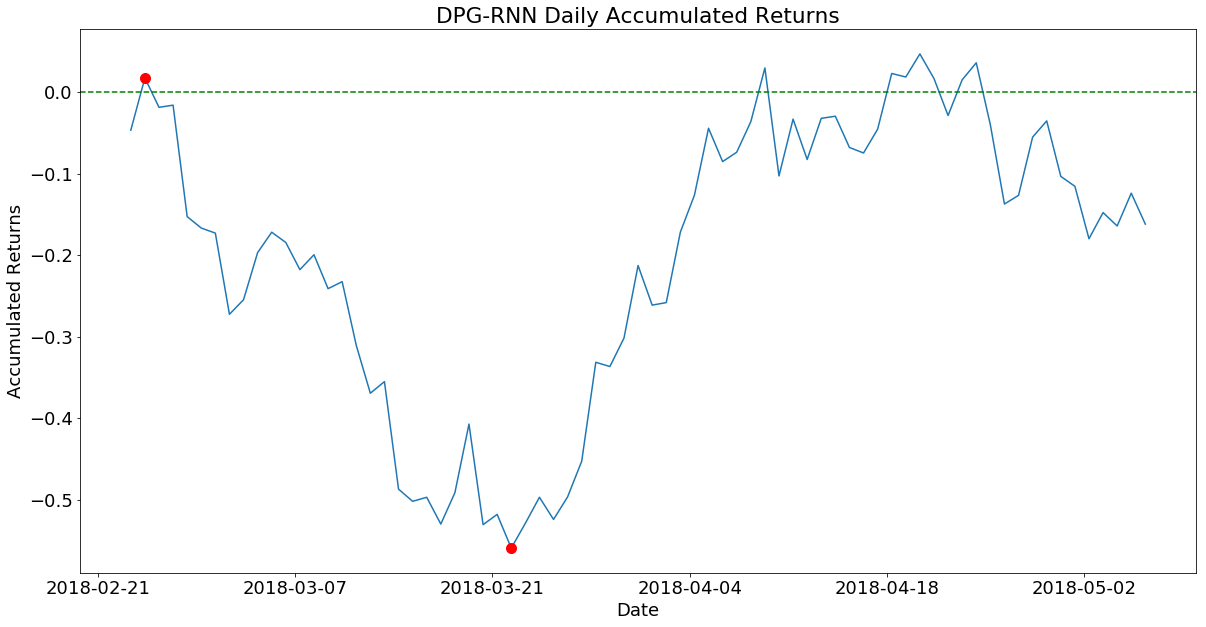

In [190]:
rnn_results(testGR)

## Backtesting

In [131]:
%autoreload

In [132]:
from backtesting import benchmarks

### Uniform buy and hold

--------------------------------------------------------------------------------
Return: -0.32
Sharpe Ratio: -1.29
Maximum Drawdown: 0.71




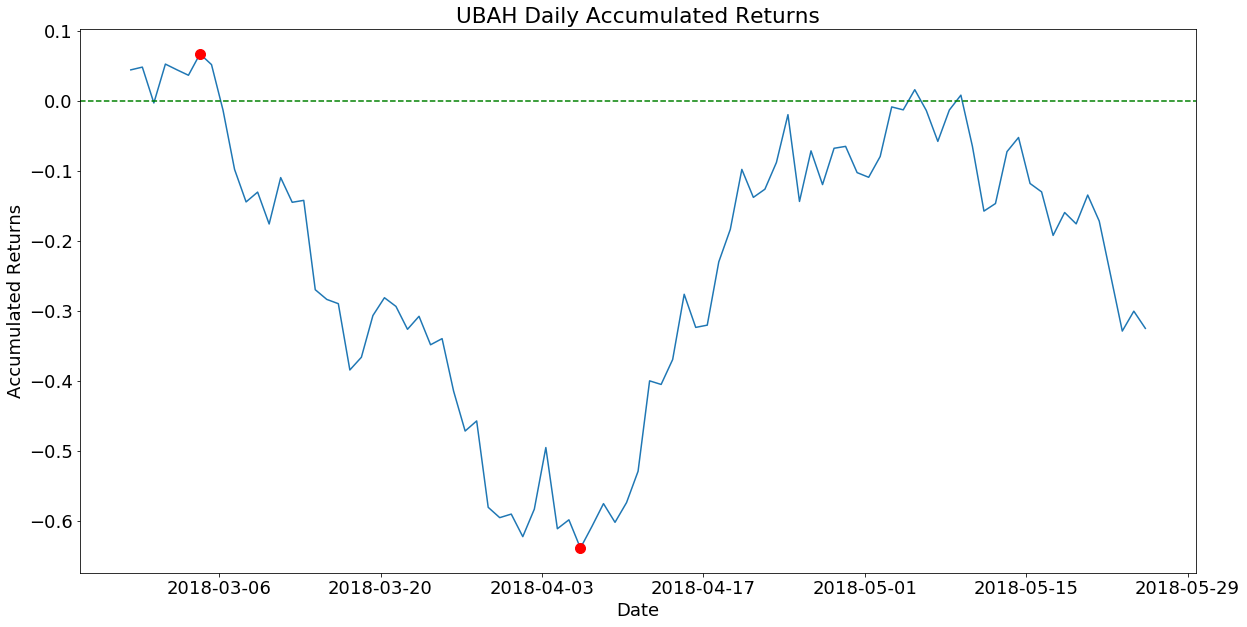

In [100]:
benchmarks.ubah(df_usdt_coins_test_data,resultsDirectory)

### Best stock

In [105]:
df_usdt_coins_test_bs_data = {}
for coin in coins_8_list:
    df_usdt_coins_test_bs_data[coin] = df_usdt_coins_historical_data[coin][-(TEST_WINDOW+VALID_WINDOW):]

In [ ]:
#rebalance_period = VALID_WINDOW
#benchmarks.bestStock(df_usdt_coins_test_bs_data,rebalance_period)

In [125]:
def print_best_stock_performance(returns,best_stock,rebalance_period,t,apv,sr,max_dd):
    print "-"*80
    print "Best Stock:", best_stock 
    print "Period:", t/rebalance_period, returns.index[t - rebalance_period], returns.index[t]
    print "Annualised Return:", round(apv,2)
    print "Annualised Sharpe Ratio:", round(sr,2)
    print "Maximum Drawdown on period:", round(max_dd,2)
    print "\n"

In [110]:
def bestStock(data, coins, rebalance_period):
    test_returns = returns_data_frame(data,return_type="log")
    best_coin_period = -np.inf
    for coin in coins:
        rol_sum = sum(test_returns[coin].iloc[:rebalance_period])
        if rol_sum > best_coin_period:
            best_coin_period = sum(test_returns[coin].iloc[:rebalance_period])
            best_stock = coin
    dd = {"max_dd":0,"min_dd":0}
    p_return_arr = []
    cum_p_return_arr = []
    for t in range(rebalance_period+1,test_returns.shape[0]):
        if t % rebalance_period == 0:
            weights = (test_returns.columns == best_stock).astype(int)
            max_dd,i,j,apv, sr, cum_p_return, p_return = portfolio_metrics(test_returns[t-rebalance_period:t],weights, plot=False, rebalanced=True)
            p_return_arr.append(p_return)
            cum_p_return_arr.append(cum_p_return)
            
            if p_return[i] < dd["min_dd"]:
                dd["min_dd"] = p_return[i]
                dd["min_dd_date"] = i
            if p_return[j] > dd["max_dd"]:
                dd["max_dd"] = p_return[j]
                dd["max_dd_date"] = j
            
            print_best_stock_performance(test_returns, best_stock, rebalance_period,t,apv,sr,max_dd)
            
            #choose the winner (best performed asset) on period [t - rebalance_period, t]
            best_coin_period = -np.inf
            for coin in coins:
                if sum(test_returns[coin].iloc[t-rebalance_period:t]) > best_coin_period:
                    best_coin_period = sum(test_returns[coin].iloc[1:rebalance_period])
                    best_stock = coin
        if t == test_returns.shape[0]-1:
            weights = (test_returns.columns == best_stock).astype(int)
            max_dd,i,j,apv, sr, cum_p_return, p_return = portfolio_metrics(test_returns[t-rebalance_period:],weights, plot=False, rebalanced=True)
            p_return_arr.append(p_return)
            cum_p_return_arr.append(cum_p_return)
            
            if p_return[i] < dd["min_dd"]:
                dd["min_dd"] = p_return[i]
                dd["min_dd_date"] = i
            if p_return[j] > dd["max_dd"]:
                dd["max_dd"] = p_return[j]
                dd["max_dd_date"] = j
            print_best_stock_performance(test_returns, best_stock, rebalance_period,t,apv,sr,max_dd)
    weighted_p_return = pd.concat(p_return_arr)
    final_cum_p_return = pd.concat(cum_p_return_arr)
    
    apv = final_cum_p_return[-1]
    sr = np.sqrt(365)* (np.mean(weighted_p_return) / np.std(weighted_p_return))
    max_dd = final_cum_p_return[dd["max_dd_date"]]-final_cum_p_return[dd["min_dd_date"]]
    print_portfolio_perfomance(apv,sr,max_dd)
    plot_portfolio_backtest(final_cum_p_return, dd["min_dd_date"], dd["max_dd_date"],"BEST Daily Accumulated Returns")

--------------------------------------------------------------------------------
Best Stock: LTC
Period: 2 2018-02-26 08:00:00 2018-03-28 08:00:00
Annualised Return: -0.48
Annualised Sharpe Ratio: -6.52
Maximum Drawdown on period: 0.48


--------------------------------------------------------------------------------
Best Stock: BTC
Period: 3 2018-03-28 08:00:00 2018-04-27 08:00:00
Annualised Return: 0.18
Annualised Sharpe Ratio: 2.25
Maximum Drawdown on period: 0.18


--------------------------------------------------------------------------------
Best Stock: BCN
Period: 3 2018-04-25 08:00:00 2018-05-25 08:00:00
Annualised Return: 0.2
Annualised Sharpe Ratio: 0.82
Maximum Drawdown on period: 0.73


--------------------------------------------------------------------------------
Return: 0.2
Sharpe Ratio: -0.23
Maximum Drawdown: 1.42




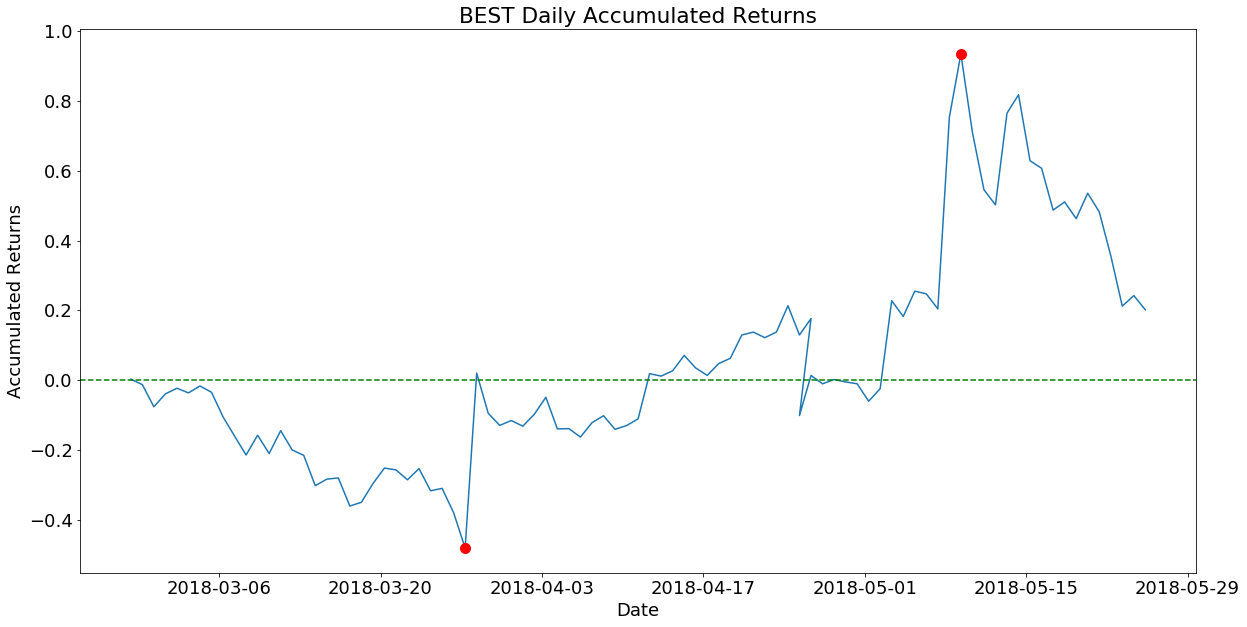

In [111]:
bestStock(df_usdt_coins_test_bs_data,coins_8_list,VALID_WINDOW)

### Markowitz portfolio

In [172]:
%autoreload

In [173]:
from markowitz import portfolio

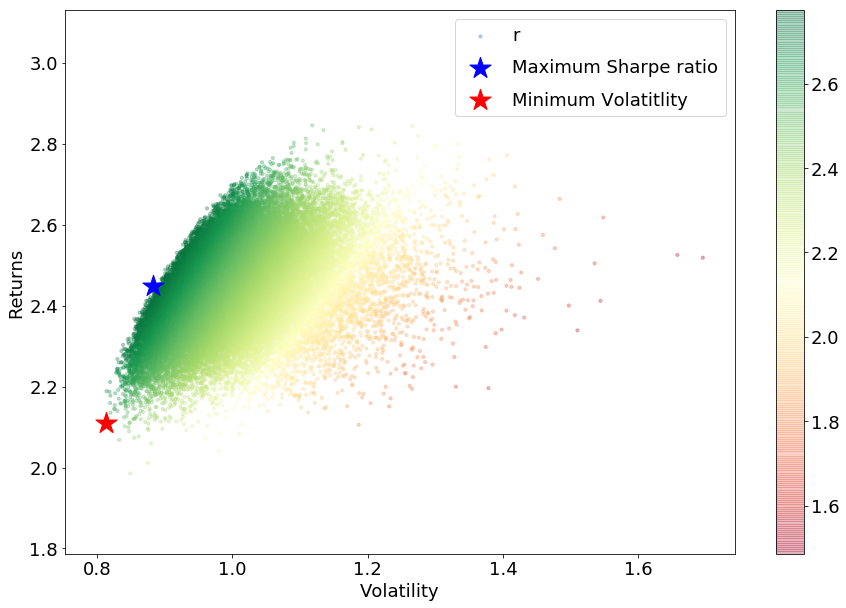

In [157]:
portfolio.random_portfolio(df_returns_train, 50000)

#### Calculating efficient frontier

Let's try to plot the portfolio choice with maximum Sharpe ratio and minimum volatility also with all the randomly generated portfolios. But this time we are not picking the optimal ones from the randomly generated portfolios, but we are actually calculating by using Scipy's 'minimize' function. And the below function will also plot the efficient frontier line.

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 2.42
Annualised Volatility: 0.87


DASH    24.07
BCN      0.00
XEM     10.03
LTC      3.09
BTC     19.36
ETH     19.32
XRP     10.71
XMR     13.43
dtype: float64
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 1.88
Annualised Volatility: 0.76


DASH    13.88
BCN      0.00
XEM      0.00
LTC      0.97
BTC     64.45
ETH     11.91
XRP      8.79
XMR      0.00
dtype: float64


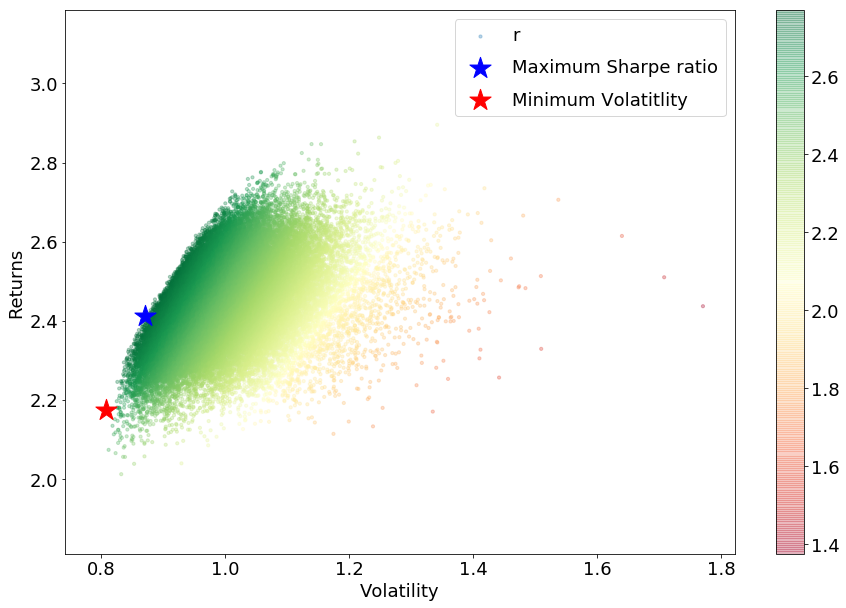

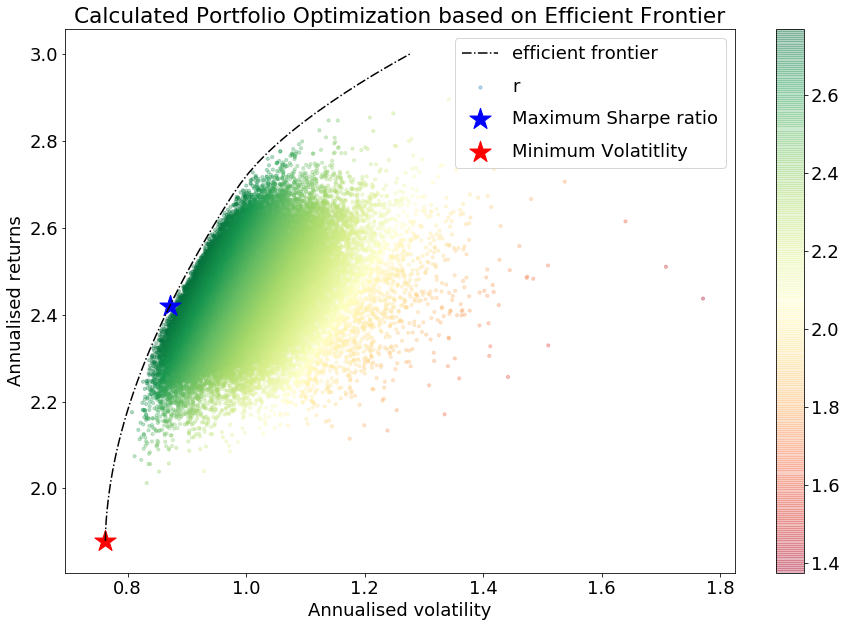

In [174]:
max_sharpe_allocation, min_var_allocation = portfolio.ef_with_random(df_returns_train, 50000)

### Backtesting without rebalancing

In [173]:
def markowitz_backtesting(max_shape_allocation, min_variance_allocation, data):
    test_returns = returns_data_frame(data,return_type="log")
    max_dd_ms, apv_ms, sharpe_ratio_ms = portfolio_metrics(test_returns,max_sharpe_allocation,"MSR Daily Accumulated Returns")
    max_dd_mv, apv_mv, sharpe_ratio_mv = portfolio_metrics(test_returns,min_variance_allocation,"MV Daily Accumulated Returns")
    print_portfolio_perfomance(apv_ms,sharpe_ratio_ms,max_dd_ms)
    print_portfolio_perfomance(apv_mv,sharpe_ratio_mv,max_dd_mv)

--------------------------------------------------------------------------------
Return: -0.31
Sharpe Ratio: -1.32
Maximum Drawdown: 0.72


--------------------------------------------------------------------------------
Return: -0.23
Sharpe Ratio: -1.08
Maximum Drawdown: 0.64




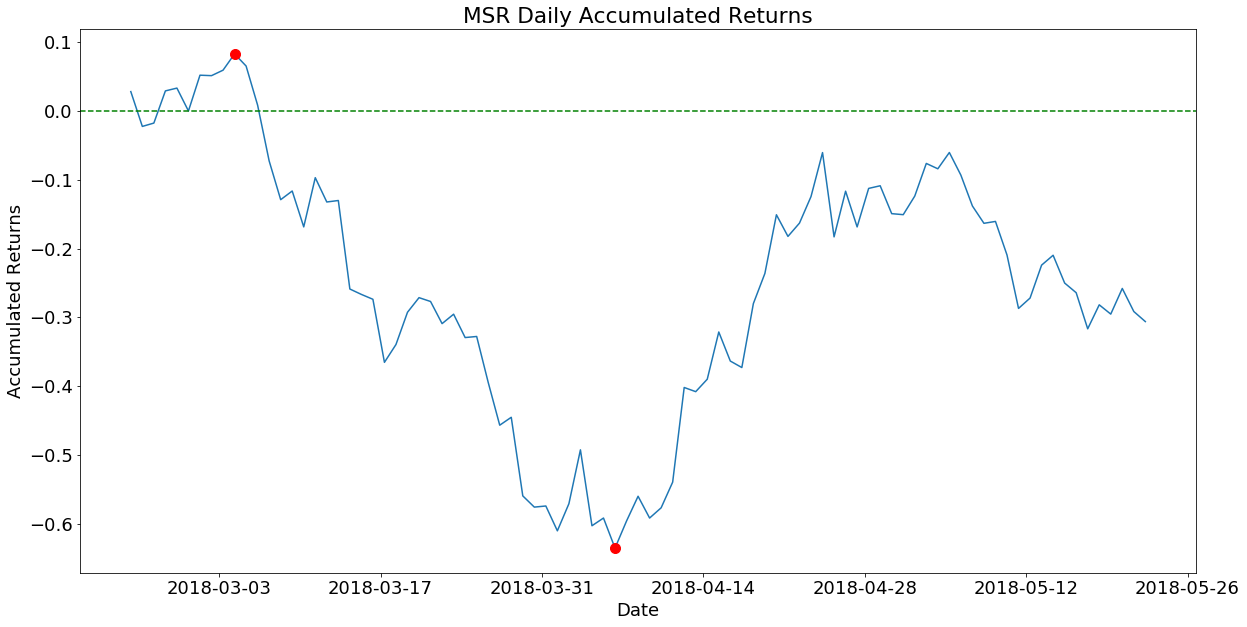

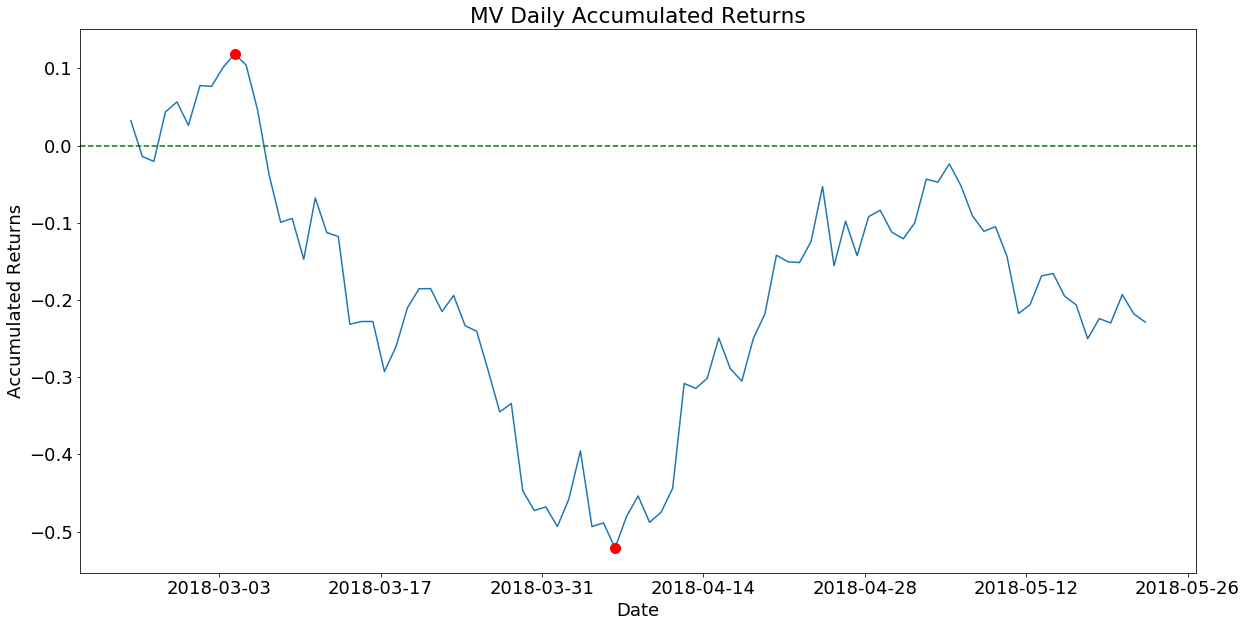

In [174]:
markowitz_backtesting(max_sharpe_allocation,min_var_allocation,df_usdt_coins_test_data)

In [182]:
def print_markowitz_performance(returns,rebalance_period,t,apv,sr,max_dd,p_type):
    print "-"*80
    if p_type == "ms":
        print "Maximum Sharpe Ratio"
    if p_type == "mv": 
        print "Minimum Volatility"
    print "Period:", t/rebalance_period, returns.index[t - rebalance_period], returns.index[t]
    print "Annualised Return:", round(apv,2)
    print "Annualised Sharpe Ratio:", round(sr,2)
    print "Maximum Drawdown on period:", round(max_dd,2)
    print "\n"

In [187]:
def markowitz_backtesting_rb(max_shape_allocation, min_variance_allocation, data, rebalance_period):
    coins = data.keys()
    test_returns = returns_data_frame(data,return_type="log")
    
    coins = test_returns.columns
    dd_ms = {"max_dd":0,"min_dd":0}
    dd_mv = {"max_dd":0,"min_dd":0}
    p_return_arr_ms = []
    p_return_arr_mv = []
    
    cum_p_return_arr_ms = []
    cum_p_return_arr_mv = []
    
    max_dd_ms, i_ms, j_ms, apv_ms, sr_ms, cum_p_return_ms, p_return_ms = portfolio_metrics(test_returns[:rebalance_period],max_shape_allocation,plot=False, rebalanced=True)
    max_dd_mv, i_mv, j_mv, apv_mv, sr_mv, cum_p_return_mv, p_return_mv = portfolio_metrics(test_returns[:rebalance_period],min_variance_allocation,plot=False, rebalanced=True)
    
    print_markowitz_performance(test_returns,rebalance_period,30,apv_ms,sr_ms,max_dd_ms,"ms")
    print_markowitz_performance(test_returns,rebalance_period,30,apv_mv,sr_mv,max_dd_mv,"mv")
    
    p_return_arr_ms.append(p_return_ms)
    cum_p_return_arr_ms.append(cum_p_return_ms)
    if p_return_ms[i_ms] < dd_ms["min_dd"]:
        dd_ms["min_dd"] = p_return_ms[i_ms]
        dd_ms["min_dd_date"] = i_ms
    if p_return_ms[j_ms] > dd_ms["max_dd"]:
        dd_ms["max_dd"] = p_return_ms[j_ms]
        dd_ms["max_dd_date"] = j_ms
        
    p_return_arr_mv.append(p_return_mv)
    cum_p_return_arr_mv.append(cum_p_return_mv)
    if p_return_mv[i_mv] < dd_mv["min_dd"]:
        dd_mv["min_dd"] = p_return_mv[i_mv]
        dd_mv["min_dd_date"] = i_mv
    if p_return_mv[j_mv] > dd_mv["max_dd"]:
        dd_mv["max_dd"] = p_return_mv[j_mv]
        dd_mv["max_dd_date"] = j_mv
    
    for t in range(rebalance_period+1,test_returns.shape[0]):
        if t % rebalance_period == 0:
            max_shape_allocation, min_variance_allocation =  ef_with_random(test_returns[t-rebalance_period:t], 50000, print_results=False)
            max_dd_ms, i_ms, j_ms, apv_ms, sr_ms, cum_p_return_ms, p_return_ms = portfolio_metrics(test_returns[t-rebalance_period:t],max_shape_allocation,plot=False, rebalanced=True)
            max_dd_mv, i_mv, j_mv, apv_mv, sr_mv, cum_p_return_mv, p_return_mv = portfolio_metrics(test_returns[t-rebalance_period:t],min_variance_allocation,plot=False, rebalanced=True)
            
            print_markowitz_performance(test_returns,rebalance_period,t,apv_ms,sr_ms,max_dd_ms,"ms")
            print_markowitz_performance(test_returns,rebalance_period,t,apv_mv,sr_mv,max_dd_mv,"mv")
            
            p_return_arr_ms.append(p_return_ms)
            cum_p_return_arr_ms.append(cum_p_return_ms)
            if p_return_ms[i_ms] < dd_ms["min_dd"]:
                dd_ms["min_dd"] = p_return_ms[i_ms]
                dd_ms["min_dd_date"] = i_ms
            if p_return_ms[j_ms] > dd_ms["max_dd"]:
                dd_ms["max_dd"] = p_return_ms[j_ms]
                dd_ms["max_dd_date"] = j_ms

            p_return_arr_mv.append(p_return_mv)
            cum_p_return_arr_mv.append(cum_p_return_mv)
            if p_return_mv[i_mv] < dd_mv["min_dd"]:
                dd_mv["min_dd"] = p_return_mv[i_mv]
                dd_mv["min_dd_date"] = i_mv
            if p_return_mv[j_mv] > dd_mv["max_dd"]:
                dd_mv["max_dd"] = p_return_mv[j_mv]
                dd_mv["max_dd_date"] = j_mv
                
        if t == test_returns.shape[0]-1:
            max_dd_ms, i_ms, j_ms, apv_ms, sr_ms, cum_p_return_ms, p_return_ms = portfolio_metrics(test_returns[t-rebalance_period:],max_shape_allocation,plot=False, rebalanced=True)
            max_dd_mv, i_mv, j_mv, apv_mv, sr_mv, cum_p_return_mv, p_return_mv = portfolio_metrics(test_returns[t-rebalance_period:],min_variance_allocation,plot=False, rebalanced=True)
            
            print_markowitz_performance(test_returns,rebalance_period,t,apv_ms,sr_ms,max_dd_ms,"ms")
            print_markowitz_performance(test_returns,rebalance_period,t,apv_mv,sr_mv,max_dd_mv,"mv")
            
            p_return_arr_ms.append(p_return_ms)
            cum_p_return_arr_ms.append(cum_p_return_ms)
            if p_return_ms[i_ms] < dd_ms["min_dd"]:
                dd_ms["min_dd"] = p_return_ms[i_ms]
                dd_ms["min_dd_date"] = i_ms
            if p_return_ms[j_ms] > dd_ms["max_dd"]:
                dd_ms["max_dd"] = p_return_ms[j_ms]
                dd_ms["max_dd_date"] = j_ms

            p_return_arr_mv.append(p_return_mv)
            cum_p_return_arr_mv.append(cum_p_return_mv)
            if p_return_mv[i_mv] < dd_mv["min_dd"]:
                dd_mv["min_dd"] = p_return_mv[i_mv]
                dd_mv["min_dd_date"] = i_mv
            if p_return_mv[j_mv] > dd_mv["max_dd"]:
                dd_mv["max_dd"] = p_return_mv[j_mv]
                dd_mv["max_dd_date"] = j_mv
    
    weighted_p_return_ms = pd.concat(p_return_arr_ms)
    weighted_p_return_mv = pd.concat(p_return_arr_mv)
    final_cum_p_return_ms = pd.concat(cum_p_return_arr_ms)
    final_cum_p_return_mv = pd.concat(cum_p_return_arr_mv)
    
    apv_ms = final_cum_p_return_ms[-1]
    sr_ms = np.sqrt(365)* (np.mean(weighted_p_return_ms) / np.std(weighted_p_return_ms))
    max_dd_ms = final_cum_p_return_ms[dd_ms["max_dd_date"]]-final_cum_p_return_ms[dd_ms["min_dd_date"]]
    print_portfolio_perfomance(apv_ms,sr_ms,max_dd_ms)
    
    apv_mv = final_cum_p_return_mv[-1]
    sr_mv = np.sqrt(365)* (np.mean(weighted_p_return_mv) / np.std(weighted_p_return_mv))
    max_dd_mv = final_cum_p_return_mv[dd_mv["max_dd_date"]]-final_cum_p_return_mv[dd_mv["min_dd_date"]]
    print_portfolio_perfomance(apv_mv,sr_mv,max_dd_mv)
    
    plot_portfolio_backtest(final_cum_p_return_ms, dd_ms["min_dd_date"], dd_ms["max_dd_date"],"MSR Daily Accumulated Returns")
    plot_portfolio_backtest(final_cum_p_return_mv, dd_mv["min_dd_date"], dd_mv["max_dd_date"],"MV Daily Accumulated Returns")

--------------------------------------------------------------------------------
Maximum Sharpe Ratio
Period: 1 2018-02-23 08:00:00 2018-03-25 08:00:00
Annualised Return: -0.33
Annualised Sharpe Ratio: -4.62
Maximum Drawdown on period: 0.45


--------------------------------------------------------------------------------
Minimum Volatility
Period: 1 2018-02-23 08:00:00 2018-03-25 08:00:00
Annualised Return: -0.23
Annualised Sharpe Ratio: -3.27
Maximum Drawdown on period: 0.41


--------------------------------------------------------------------------------
Maximum Sharpe Ratio
Period: 2 2018-03-25 08:00:00 2018-04-24 08:00:00
Annualised Return: 0.69
Annualised Sharpe Ratio: 5.31
Maximum Drawdown on period: 0.28


--------------------------------------------------------------------------------
Minimum Volatility
Period: 2 2018-03-25 08:00:00 2018-04-24 08:00:00
Annualised Return: 0.05
Annualised Sharpe Ratio: 0.63
Maximum Drawdown on period: 0.25


------------------------------------

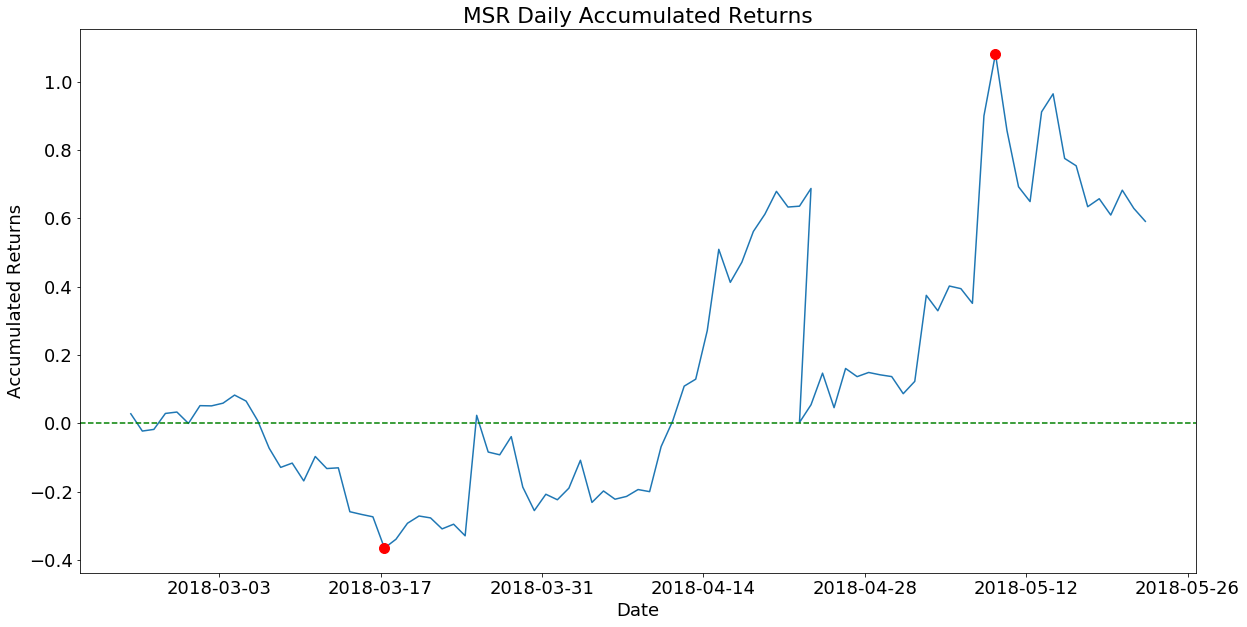

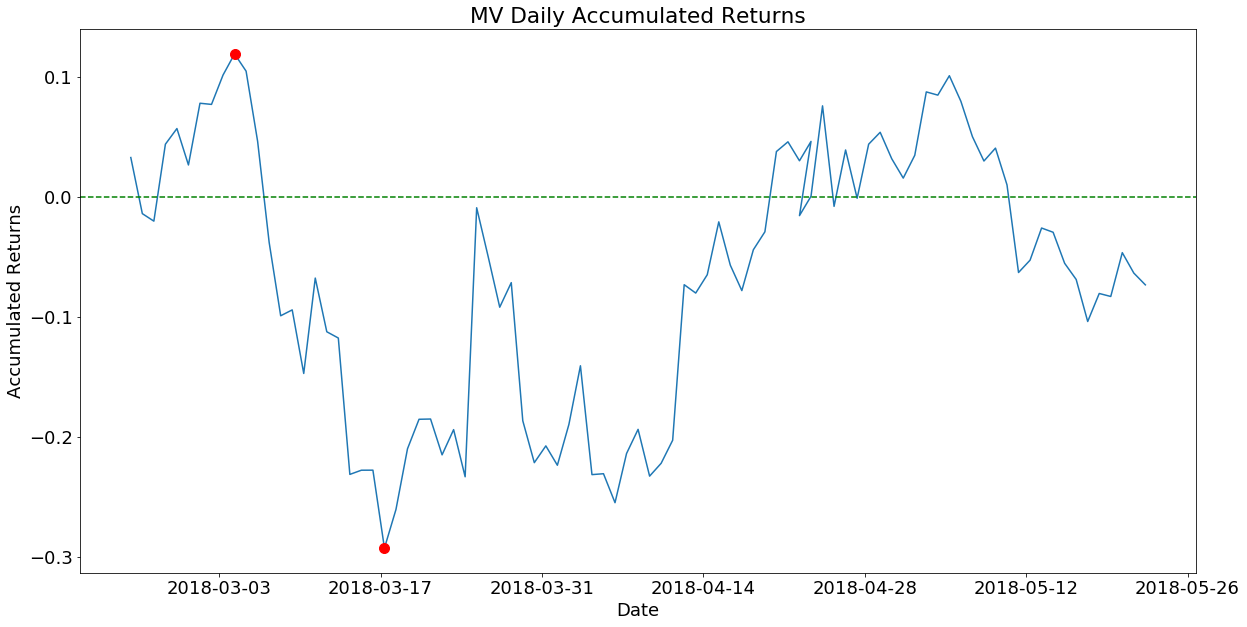

In [188]:
markowitz_backtesting_rb(max_sharpe_allocation, min_var_allocation, df_usdt_coins_test_data, VALID_WINDOW)